#### Task 1
 Set up and Data preparation
 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


#Load a part of the data to make things faster
df = pd.read_csv("../data/transactions_train.csv").head(500000)

#Preprocessing the IDS into continuous integer codes that the embedding layer can use.

#creating user and item encoders
user_encoder = LabelEncoder()
article_encoder = LabelEncoder()

# Fit and transform the IDs to integer codes
df['user_code'] = user_encoder.fit_transform(df['customer_id'])
df['article_code'] = article_encoder.fit_transform(df['article_id'])

# Get the number of unique users and articles
n_users = df['user_code'].nunique()
n_articles = df['article_code'].nunique()

print(f"Number of unique users: {n_users}")
print(f"Number of unique articles: {n_articles}")


#Creating Training Data
# Positive examples (the ones we have)
X = df[['user_code', 'article_code']].values #to create numpy array of the user and the item beside
y = np.ones(len(df)) # All are purchases, so target is 1,an array of 1's as the target

# In a full project, we would add "negative samples" here (target=0) so that we can allow the model know or understand when the user didn't buy 
# For today, we will skip this step to focus on the model architecture.







Number of unique users: 119904
Number of unique articles: 24942


In [2]:
# Create DataFrame for user mapping
user_mapping = pd.DataFrame({
    'user_code': range(len(user_encoder.classes_)),
    'customer_id': user_encoder.classes_
})

# Create DataFrame for article mapping
article_mapping = pd.DataFrame({
    'article_code': range(len(article_encoder.classes_)),
    'article_id': article_encoder.classes_
})

print(user_mapping.head())
print(article_mapping.head())


   user_code                                        customer_id
0          0  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
1          1  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
2          2  00007d2de826758b65a93dd24ce629ed66842531df6699...
3          3  0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...
4          4  00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d...
   article_code  article_id
0             0   108775015
1             1   108775044
2             2   108775051
3             3   110065001
4             4   110065002


#### Task 2
Building the Model Architecture

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define embedding size
embedding_dim = 32

# --- User Input Pathway ---
user_input = layers.Input(shape=(1,), name='user_input')#one input only
user_embedding = layers.Embedding(n_users, embedding_dim, name='user_embedding')(user_input)
user_vec = layers.Flatten(name='flatten_user')(user_embedding)

# --- Article Input Pathway ---
article_input = layers.Input(shape=(1,), name='article_input') #shape 1 means it would accept one input only
article_embedding = layers.Embedding(n_articles, embedding_dim, name='article_embedding')(article_input)
article_vec = layers.Flatten(name='flatten_article')(article_embedding)

# --- Combine & Create Model ---
concatenated = layers.Concatenate()([user_vec, article_vec])
dense_1 = layers.Dense(128, activation='relu')(concatenated)
dense_2 = layers.Dense(64, activation='relu')(dense_1)
output = layers.Dense(1, activation='sigmoid')(dense_2) # Sigmoid for 0-1 probability

model = keras.Model(inputs=[user_input, article_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ article_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │  3,836,928 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ article_embedding   │ (None, 1, 32)     │    798,144 │ article_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_user        │ (None, 32)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_article     │ (None, 32)        │          0 │ article_embeddin… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ flatten_user[0][… │
│ (Concatenate)       │                   │            │ flatten_article[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,651,713 (17.74 MB)

 Trainable params: 4,651,713 (17.74 MB)

 Non-trainable params: 0 (0.00 B)

Generating Negative samples

In [4]:
# Encode article IDs in df before creating user_purchases
df['article_code'] = article_encoder.transform(df['article_id'])
df['user_code'] = user_encoder.transform(df['customer_id'])

# Filter articles to match CF model indices
max_article_index = 24942  # Replace with your CF model max index
df = df[df['article_code'] < max_article_index]

# Create a set of all unique article codes for fast lookup
all_article_codes = set(df['article_code'].unique())

# Create dictionary of items purchased by each user
user_purchases = df.groupby('user_code')['article_code'].apply(set).to_dict()

# Generate negative samples
neg_samples = []
for user_code in df['user_code'].unique():
    purchased_articles = user_purchases[user_code]
    unpurchased_articles = all_article_codes - purchased_articles
    num_positives = len(purchased_articles)
    neg_items = np.random.choice(list(unpurchased_articles), size=num_positives, replace=False)
    for item_code in neg_items:
        neg_samples.append([user_code, item_code, 0])

# Negative samples DataFrame
neg_df = pd.DataFrame(neg_samples, columns=['user_code', 'article_code', 'target'])

# Positive samples DataFrame
pos_df = df[['user_code', 'article_code']].copy()
pos_df['target'] = 1

# Final training DataFrame
final_df = pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

print(f"Total training samples: {len(final_df)}")
display(final_df.head())


Total training samples: 947349


,user_code,article_code,target
0,28739,23346,0
1,111039,2941,1
2,88857,3819,1
3,26173,10722,1
4,81366,9201,1


Training the model

In [5]:
X_train = [final_df['user_code'], final_df['article_code']]
y_train = final_df['target']

# (Re-run the cell where you defined and compiled your model architecture)

print("Starting model training on balanced data...")
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=5,       # Keep epochs low for today's exercise
    batch_size=256,
    validation_split=0.1, # Use 10% of the data for validation
    verbose=1
)
print("Training finished.")


Starting model training on balanced data...
Epoch 1/5
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 130s 38ms/step - accuracy: 0.7206 - loss: 0.5410 - val_accuracy: 0.7757 - val_loss: 0.4709
Epoch 2/5
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 131s 39ms/step - accuracy: 0.8031 - loss: 0.4152 - val_accuracy: 0.7852 - val_loss: 0.4607
Epoch 3/5
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 130s 39ms/step - accuracy: 0.8550 - loss: 0.3224 - val_accuracy: 0.7837 - val_loss: 0.4999
Epoch 4/5
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 132s 40ms/step - accuracy: 0.9180 - loss: 0.1972 - val_accuracy: 0.7698 - val_loss: 0.6245
Epoch 5/5
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 121s 36ms/step - accuracy: 0.9675 - loss: 0.0875 - val_accuracy: 0.7614 - val_loss: 0.9447
Training finished.


### Strategy for Generating Recommendations

To get the top 10 recommendations for a specific user (`user_X`):

1.  **Identify Candidate Items**: Get a list of all unique article codes that the user has *not* previously purchased.
2.  **Create User-Item Pairs**: Create a DataFrame with two columns: one repeating `user_X`'s code, and the other containing all the candidate article codes.
3.  **Predict Probabilities**: Use `model.predict()` on these pairs. The model will output a "purchase probability" for each candidate item.
4.  **Rank and Select**: Sort the articles based on their predicted probability in descending order.
5.  **Return Top-K**: The top 10 articles from this sorted list are the final recommendations.


#### Plot Training History



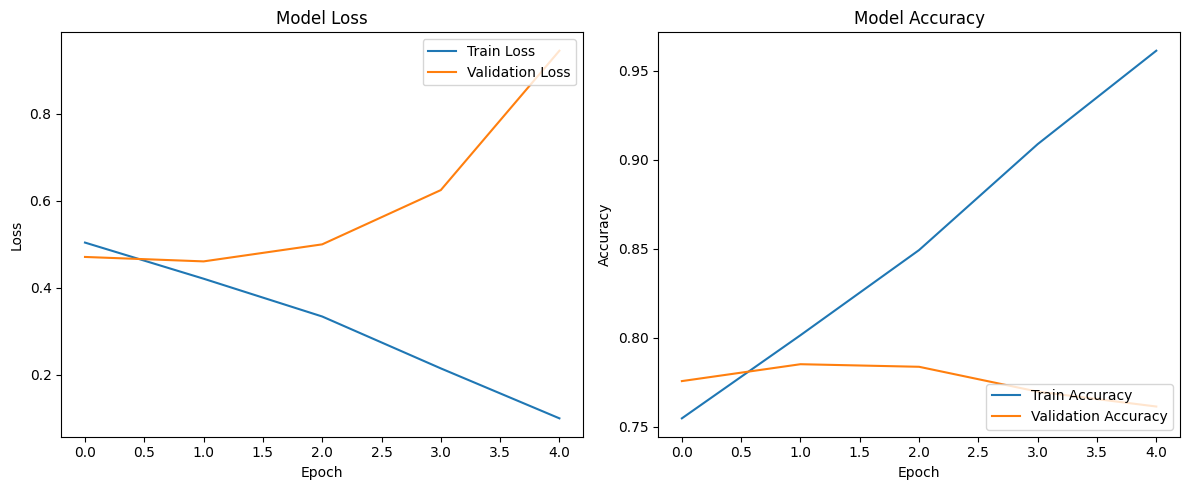

In [6]:
import matplotlib.pyplot as plt

# plot training & validation loss values
plt.figure(figsize=(12,5)) #creates the width and size of how the whole plot would be
plt.subplot(1,2,1) #the first 1 is the n_row,2 is n_column and last 1 is the position which is left side
plt.plot(history.history['loss'], label='Train Loss') #when we use fit() it returns and history object which is stored in an history variable so to access it,we do history.history[]
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right') #shows what each colour line on the graph shows using the label we did above


#Plot training & validation accuracy values
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout() # To create enough space for each plot and prevent overlapping
plt.show()#normal py file won't show the plot without this



#### Are there signs of overfitting?
There are,from the look of the first plot the curve of the loss train tends to converge i.e reduces as it completes each epoch, but the validation loss tends to increase as each epoch completes therefore leads to overfitting.
Observing the second plot the train accuracy increases as it completes each epoch while the validation accurach reduces therefore leads to overfitting.

#### Extracting and Visualizing Article Embeddings


Shape of article embeddings: (24942, 32)


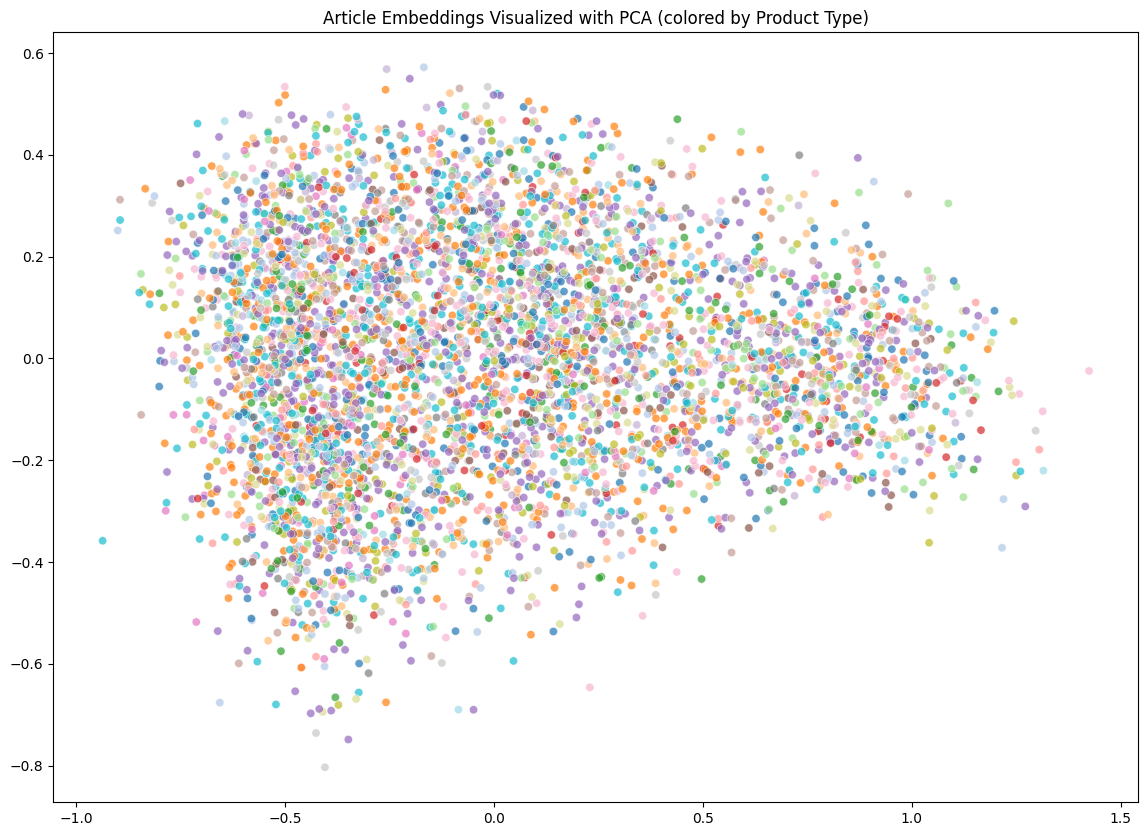

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns
articles_df = pd.read_csv('../data/articles.csv') 


#Get the embedding layer
article_embedding_layer = model.get_layer('article_embedding')

#Get the weights(the learned embeddings)
article_embeddings = article_embedding_layer.get_weights()[0] #the vector weights

print(f"Shape of article embeddings: {article_embeddings.shape}")



#Reducing the Dimensionality with PCA(principal Component Analysis)


#Using PCA to reduce dimensions from 32 to 2
pca = PCA(n_components=2) #selecting the number of dimensions to reduce to

article_embeddings_2d =pca.fit_transform(article_embeddings)


#Visualizing the 2D embedding

unique_product_types = articles_df['product_type_name'].unique()
articles_df_subset = articles_df.drop_duplicates(subset=['article_id']).copy()

article_encoder = LabelEncoder()
article_encoder.fit(articles_df_subset['article_id'])
articles_df_subset['article_code'] = article_encoder.transform(articles_df_subset['article_id'])

# Create a mapping from article_code to product_type_name
code_to_type = articles_df_subset.set_index('article_code')['product_type_name']

# We'll visualize a random sample to avoid overplotting
sample_indices = np.random.choice(len(article_embeddings_2d), size=5000, replace=False)#Random rows

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=article_embeddings_2d[sample_indices, 0],
    y=article_embeddings_2d[sample_indices, 1],
    hue=[code_to_type.get(i, 'Unknown') for i in sample_indices],# This row is saying for every sample indexcontaining a random row number use it to look up the product name then colour the points based on it's product type.hue is used to colour the data points based on a category or label
    palette="tab20",#Transparency of the plot elements
    alpha=0.7,
    legend=False # Legend would be too crowded
)
plt.title('Article Embeddings Visualized with PCA (colored by Product Type)')
plt.show()







In [8]:
import joblib
from tensorflow.keras.models import save_model

save_model(model, "../artifacts/collab_model.h5")        # Save the trained CF model
joblib.dump(user_encoder, "../artifacts/user_encoder.pkl")   # Save user ID mapping
joblib.dump(article_encoder, "../artifacts/article_encoder.pkl") # Save article ID mapping
joblib.dump(user_purchases,"../artifacts/user_purchases.pkl")



['../artifacts/user_purchases.pkl']

In [11]:
# Sanity check after building user_purchases
max_article_index = 24942  # CF model max

# 1. Check if any article_code is out of range
all_articles_in_purchases = set().union(*user_purchases.values())
bad_articles = [a for a in all_articles_in_purchases if a >= max_article_index]

print(f"Total unique articles in user_purchases: {len(all_articles_in_purchases)}")
print(f"Number of out-of-range articles: {len(bad_articles)}")
if bad_articles:
    print("Sample bad articles:", bad_articles[:20])
else:
    print("✅ All article indices are within CF model range.")

# 2. Check if df itself has bad article_codes
bad_df = df[df['article_code'] >= max_article_index]
print(f"Bad rows in df: {len(bad_df)}")
if not bad_df.empty:
    display(bad_df.head())


Total unique articles in user_purchases: 24942
Number of out-of-range articles: 0
✅ All article indices are within CF model range.
Bad rows in df: 0


In [12]:
# -------------------------------
# Debug Checks before saving
# -------------------------------

print("🔎 Debugging Encoders and Model")

# 1. Check article encoder range
max_article_code = df['article_code'].max()
n_articles_from_encoder = len(article_encoder.classes_)
print(f"Max article_code in df: {max_article_code}")
print(f"Article encoder classes: {n_articles_from_encoder}")

# 2. Check user encoder range
max_user_code = df['user_code'].max()
n_users_from_encoder = len(user_encoder.classes_)
print(f"Max user_code in df: {max_user_code}")
print(f"User encoder classes: {n_users_from_encoder}")

# 3. Check model embedding input shapes
article_emb_input = model.get_layer("article_embedding").input_dim
user_emb_input = model.get_layer("user_embedding").input_dim
print(f"Article embedding input_dim: {article_emb_input}")
print(f"User embedding input_dim: {user_emb_input}")

# 4. Verify user_purchases dictionary
user_purchases_articles = set().union(*user_purchases.values())
max_article_in_user_purchases = max(user_purchases_articles)
print(f"Max article_code in user_purchases: {max_article_in_user_purchases}")

# -------------------------------
# Final consistency check
# -------------------------------
print("\n✅ Consistency check:")
if max_article_code >= article_emb_input:
    print("❌ ERROR: Article encoder produces IDs outside model embedding range.")
else:
    print("✅ Article encoder matches model.")

if max_user_code >= user_emb_input:
    print("❌ ERROR: User encoder produces IDs outside model embedding range.")
else:
    print("✅ User encoder matches model.")

if max_article_in_user_purchases >= article_emb_input:
    print("❌ ERROR: user_purchases contains out-of-range article indices.")
else:
    print("✅ user_purchases is safe.")


🔎 Debugging Encoders and Model
Max article_code in df: 24941
Article encoder classes: 105542
Max user_code in df: 119903
User encoder classes: 119904
Article embedding input_dim: 24942
User embedding input_dim: 119904
Max article_code in user_purchases: 24941

✅ Consistency check:
✅ Article encoder matches model.
✅ User encoder matches model.
✅ user_purchases is safe.
